In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
import graphviz
import os
# import statsmodels.discrete.discrete_model as sm
import scikitplot as skplt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv', index_col = 0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Before we begin feature engineering, we split the train data into training data and test data:

In [3]:
y = df['Survived']

In [4]:
X = df[['Pclass', 'Age', 'Sex', "Embarked"]]

In [5]:
y.shape

(891,)

In [6]:
X.shape

(891, 4)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
#                                                     stratify = y, 
                                                    random_state=42)

In [8]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [9]:
y_test.value_counts()

0    134
1     89
Name: Survived, dtype: int64

In [10]:
X_train.head()

,Pclass,Age,Sex,Embarked
PassengerId,,,,
299,1,NaN,male,S
885,3,25.00,male,S
248,2,24.00,female,S
479,3,22.00,male,S
306,1,0.92,male,S


In [11]:
y_train.head()

PassengerId
299    1
885    0
248    1
479    0
306    1
Name: Survived, dtype: int64

In [12]:
X_train.shape

(668, 4)

### Feature engineering: 
* *scale* the Pclass (primarily to aid the SVM we run later)
* *one-hot-encode* the category of sex (turn it from category to binary)
* *impute* to populate the missing age values with the overall mean age
* also add missing values to embarkation point for two passengers
* create a new binary column indicating whether the passenger embarked at Cherbourg (C)
* *bin* the ages to convert from scalar to category and *one-hot-encode* to assign a 1 or 0 to each age bracket

(as a function so that we can later call it on the test data):

In [13]:
scaler = MinMaxScaler()
X = X_train['Pclass'].values.reshape(-1, 1)
scaler.fit(X)
# MinMaxScaler(copy=True, feature_range=(0,1))
X_train['Pclass_scaled'] = scaler.transform(X)

# X_train['Pclass'] = scaler.fit_transform(X_train2[['Pclass']]

/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
X_train.head()

,Pclass,Age,Sex,Embarked,Pclass_scaled
PassengerId,,,,,
299,1,NaN,male,S,0.0
885,3,25.00,male,S,1.0
248,2,24.00,female,S,0.5
479,3,22.00,male,S,1.0
306,1,0.92,male,S,0.0


In [15]:
def cleaning(dataframe):
    dataframe['Sex'] = pd.get_dummies(dataframe['Sex'], drop_first = True) #one-hot-encode to turn sex from category to binary
    dataframe['Age'].fillna(np.mean(dataframe['Age']), inplace=True) # impute to fill in the missing age values
    dataframe['Embarked'].fillna('S', inplace=True)
    dataframe['age_grp']= pd.cut(dataframe['Age'], bins = [0,12,25,45,80],duplicates='drop').astype(str)
    dummies1 = pd.get_dummies(dataframe['age_grp'], drop_first=True )
    dataframe = pd.merge(dummies1, dataframe, right_index=True, left_index=True)
    del dataframe['age_grp']
    del dataframe['Age']
    dummies2 = pd.get_dummies(dataframe['Embarked'])
    dataframe = pd.merge(dummies2, dataframe, right_index=True, left_index=True)
    del dataframe['Embarked']
    del dataframe ['Q']
    del dataframe['S']
    del dataframe['Pclass'] ### REMOVE ORIGINAL COLUMN SO IT DOESNT AFFECT FITTING
    return dataframe

In [16]:
### Breaking down Feature Engineering ###


X_train2 = X_train.copy()

X_train2['Sex'] = pd.get_dummies(X_train2['Sex'], drop_first = True) #one-hot-encode to turn sex from category to binary

X_train2['Age'].fillna(np.mean(X_train2['Age']), inplace=True) # impute to fill in the missing age values

X_train2['Embarked'].fillna('S', inplace=True)

X_train2['age_grp']= pd.cut(X_train2['Age'], bins = [0,12,25,45,80],duplicates='drop').astype(str)

dummies1 = pd.get_dummies(X_train2['age_grp'], drop_first=True )

X_train2 = pd.merge(dummies1, X_train2, right_index=True, left_index=True)

del X_train2['age_grp']
del X_train2['Age']

dummies2 = pd.get_dummies(X_train2['Embarked'])
X_train2 = pd.merge(dummies2, X_train2, right_index=True, left_index=True)

del X_train2['Embarked']
del X_train2['Q']
del X_train2['S']
del X_train2['Pclass']

X_train2.head()

,C,"(12, 25]","(25, 45]","(45, 80]",Sex,Pclass_scaled
PassengerId,,,,,,
299,0,0,1,0,1,0.0
885,0,1,0,0,1,1.0
248,0,1,0,0,0,0.5
479,0,1,0,0,1,1.0
306,0,0,0,0,1,0.0


In [17]:
cXtr = cleaning(X_train)

In [18]:
cXtr.head()

,C,"(12, 25]","(25, 45]","(45, 80]",Sex,Pclass_scaled
PassengerId,,,,,,
299,0,0,1,0,1,0.0
885,0,1,0,0,1,1.0
248,0,1,0,0,0,0.5
479,0,1,0,0,1,1.0
306,0,0,0,0,1,0.0


### Next, we define, fit and examine model:

In [19]:
m = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)

In [20]:
m.fit(cXtr, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
m.score(cXtr, y_train) # Calculate the accuracy of the model

0.7889221556886228

In [22]:
m.coef_

array([[ 0.58556513, -1.08358022, -0.9156158 , -1.30984272, -2.48747809,
        -1.75788687]])

so boarding at Cherbourg has a positive influence, Pclass has a negative influence, age a smaller negative influence and sex (in this case, "maleness") a stronger negative influence on chance of survival.

In [23]:
m.intercept_

array([2.98529674])

(Interpretation of the intercept goes here)

In [24]:
Dave = [[0, 0, 1, 0, 0.5, 1]] # create a new input value called Dave

In [25]:
m.predict_proba(Dave) # predict probability of Dave first dying and then surviving (as survived = 0 --> "died")

array([[0.71746971, 0.28253029]])

so Dave has around a (xx)% chance of survival based on the input values we used

In [26]:
ypredtr = m.predict(cXtr)

In [27]:
ypredtr

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,

In [28]:
confusion_matrix(y_pred = ypredtr, y_true = y_train)

array([[349,  66],
       [ 75, 178]])

In [29]:
precision_score(y_pred = ypredtr, y_true = y_train)

0.7295081967213115

In [30]:
recall_score(y_pred = ypredtr, y_true = y_train)

0.7035573122529645

In [31]:
yprobtr = m.predict_proba(cXtr)

In [32]:
yprobtr

array([[0.60295601, 0.39704399],
       [0.91242805, 0.08757195],
       [0.26448759, 0.73551241],
       ...,
       [0.89804458, 0.10195542],
       [0.12991432, 0.87008568],
       [0.64239206, 0.35760794]])

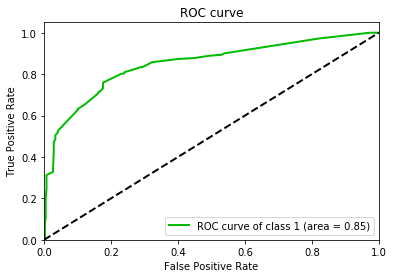

In [33]:
skplt.metrics.plot_roc(y_train, yprobtr, title = 'ROC curve', plot_micro = False, plot_macro = False, classes_to_plot = 1)

---Validate your model---

In [34]:
cross_val_score(m, cXtr, y_train, cv=5, scoring = 'accuracy')

array([0.79104478, 0.84328358, 0.73880597, 0.76691729, 0.80451128])

This produces a wider range of scores than we would like. Let's try bootstrapping:

In [35]:
boots = []
m2 = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)

for i in range(1000):
    Xb, yb = resample(cXtr, y_train)
    m2.fit(Xb, yb)
    score = m2.score(Xb, yb)
    boots.append(score)
#     print(i, score)

In [36]:
boots.sort()

In [37]:
ci80 = boots[100:-100]
print(f"80% confidence interval: {ci80[0]:5.4} -{ci80[-1]:5.4}")

80% confidence interval: 0.7769 -0.8159


In [38]:
ci90 = boots[50:-50]
print(f"90% confidence interval: {ci90[0]:5.4} -{ci90[-1]:5.4}")

90% confidence interval: 0.771 -0.8204


In [39]:
ci95 = boots[25:-25]
print(f"95% confidence interval: {ci95[0]:5.4} -{ci95[-1]:5.4}")

95% confidence interval: 0.7665 -0.8249


In [40]:
ci99 = boots[5:-5]
print(f"99% confidence interval: {ci99[0]:5.4} -{ci99[-1]:5.4}")

99% confidence interval: 0.756 -0.8323


### Let's test the same model on the X_test sample. First we clean it using the function:

In [41]:
X_test['Pclass_scaled'] = scaler.transform(X_test[['Pclass']])

X_test.head()

,Pclass,Age,Sex,Embarked,Pclass_scaled
PassengerId,,,,,
710,3,NaN,male,C,1.0
440,2,31.0,male,S,0.5
841,3,20.0,male,S,1.0
721,2,6.0,female,S,0.5
40,3,14.0,female,C,1.0


In [42]:
cXte = cleaning(X_test.copy())


In [43]:
cXtr.head(10)

,C,"(12, 25]","(25, 45]","(45, 80]",Sex,Pclass_scaled
PassengerId,,,,,,
299,0,0,1,0,1,0.0
885,0,1,0,0,1,1.0
248,0,1,0,0,0,0.5
479,0,1,0,0,1,1.0
306,0,0,0,0,1,0.0
317,0,1,0,0,0,0.5
3,0,0,1,0,0,1.0
406,0,0,1,0,1,0.5
743,1,1,0,0,0,0.0


In [44]:
cXte.head(10)

,C,"(12, 25]","(25, 45]","(45, 80]",Sex,Pclass_scaled
PassengerId,,,,,,
710,1,0,1,0,1,1.0
440,0,0,1,0,1,0.5
841,0,1,0,0,1,1.0
721,0,0,0,0,0,0.5
40,1,1,0,0,0,1.0
291,0,0,1,0,0,0.0
301,0,0,1,0,0,1.0
334,0,1,0,0,1,1.0
209,0,1,0,0,0,1.0


### Then check our scores again on this test data:

In [45]:
# cross_val_score(m, cXte, y_test, cv=5, scoring = 'accuracy')

In [46]:
# boots = []

# for i in range(1000):
#     Xb, yb = resample(cXte, y_test)
#     m.fit(Xb, yb)
#     score = m.score(Xb, yb)
#     boots.append(score)
#     print(i, score)

In [47]:
# boots.sort()

# ci80 = boots[100:-100]
# print(f"80% confidence interval: {ci80[0]:5.4} -{ci80[-1]:5.4}")

# ci90 = boots[50:-50]
# print(f"90% confidence interval: {ci90[0]:5.4} -{ci90[-1]:5.4}")

# ci95 = boots[25:-25]
# print(f"95% confidence interval: {ci95[0]:5.4} -{ci95[-1]:5.4}")

# ci99 = boots[5:-5]
# print(f"99% confidence interval: {ci99[0]:5.4} -{ci99[-1]:5.4}")

### Tune the hyperparameters for our Logistic Regression model: we do a Grid Search selecting different C-values (levels of regularisation)

In [48]:
params = {
    'C': [20.0, 15.0, 10.0, 5.0, 1.0, 0.1, 0.01, 0.001]
}
g = GridSearchCV(m, param_grid=params, cv=5, iid=False)
g.fit(cXtr, y_train)
g.score(cXtr, y_train)

0.7904191616766467

In [49]:
g.best_params_

{'C': 20.0}

Check score for Logistic Regression model on test data:

In [50]:
m.score(cXte, y_test)

0.7892376681614349

In [51]:
m.coef_

array([[ 0.58556513, -1.08358022, -0.9156158 , -1.30984272, -2.48747809,
        -1.75788687]])

# Next we will apply a random forest to our data set:

First, a decision tree:

In [52]:
t = DecisionTreeClassifier(max_depth=5)
t.fit(cXtr, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
t.score(cXtr, y_train)

0.8053892215568862

We visualise this using graphviz:

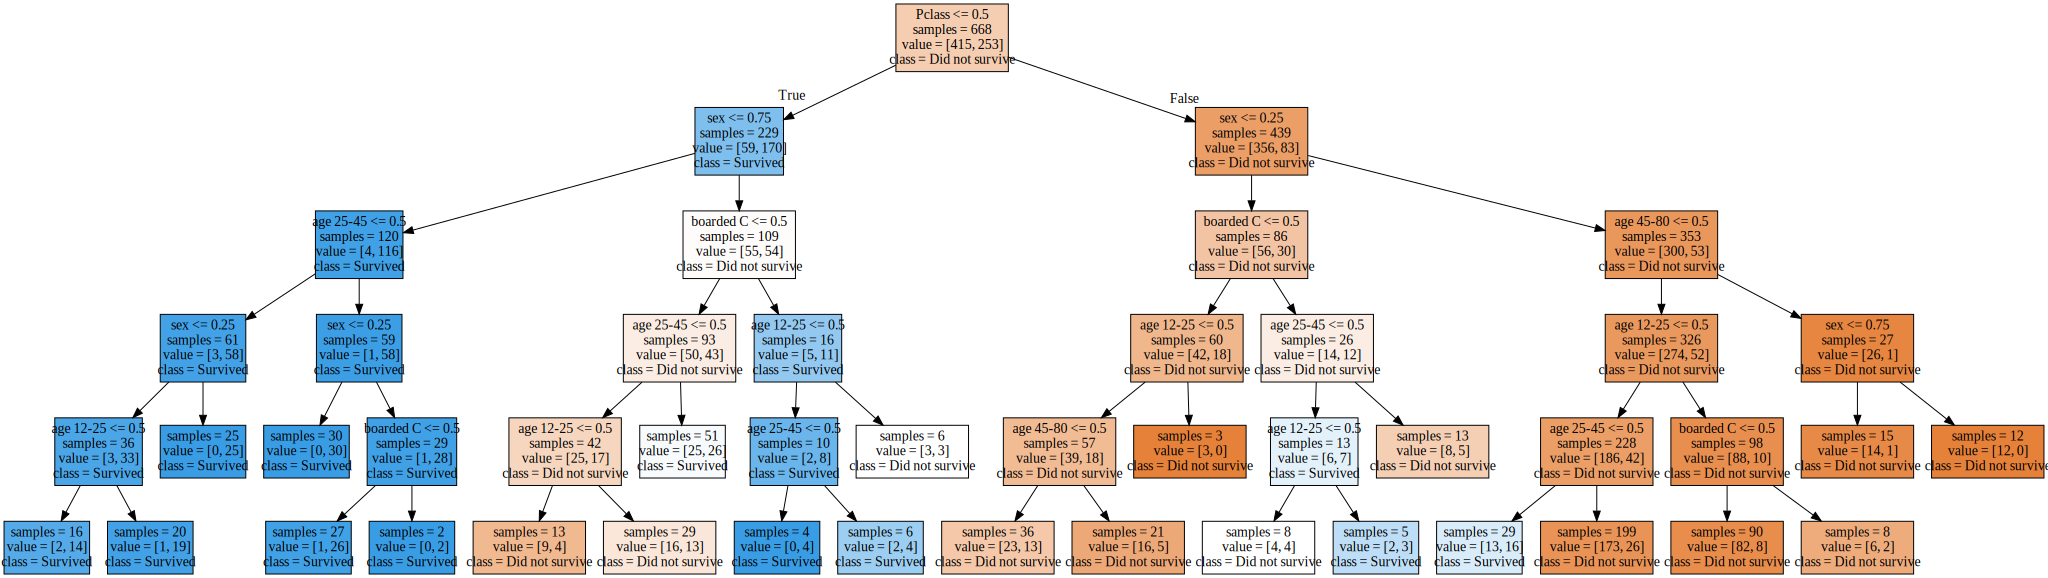

In [54]:
tree = export_graphviz(t, out_file=None, 
                class_names=["Did not survive", "Survived"],
                feature_names=['boarded C','age 12-25', 'age 25-45', 'age 45-80', "Pclass", "sex"],
                impurity=False,
                filled=True)
open('titanic.dot', 'w').write(tree)

graph = graphviz.Source(tree)
graph.render('tree')  # creates PDF
graph # displays in jupyter

Then expand this to a Random Forest:

In [55]:
rf = RandomForestClassifier()
rf.fit(cXtr, y_train)
rf.score(cXtr, y_train)

/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8188622754491018

In [56]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### To tune the hyperparameters for our Random Forest, we do a Grid Search, selecting different levels of maximum tree depth and different numbers of trees:

In [57]:
params = {
    'max_depth': [1, 2, 4, 6, 7, 8, 9, 10],
    'n_estimators': [1, 3, 5, 7, 10, 15, 20]
}
g = GridSearchCV(rf, param_grid=params, cv=5, iid=False)
g.fit(cXtr, y_train)
g.score(cXtr, y_train)

0.8188622754491018

In [58]:
g.best_params_

{'max_depth': 7, 'n_estimators': 5}

Decision tree for test data:

In [59]:
t.score(cXte, y_test)

0.757847533632287

In [60]:
rf.score(cXte, y_test)

0.757847533632287

In [61]:
g.score(cXte, y_test)

0.7488789237668162

In [62]:
# m_poly = PolynomialFeatures(2)
# n = m_poly.fit_transform(X_train)

## Now let's try a Support Vector:

In [63]:
sv = SVC()

In [64]:
sv.fit(cXtr, y_train)

/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [65]:
sv.score(cXtr, y_train)

0.7874251497005988

In [66]:
sv.score(cXte, y_test)

0.7847533632286996